In [1]:
from __future__ import division
%matplotlib notebook 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_mldata
import scipy.optimize as spopt

# L1 vs L2

## Outliers

The outlier subsection is basically taken from http://www.pyrunner.com/weblog/2016/05/26/compressed-sensing-python/

Optimization terminated successfully.
         Current function value: 1.184370
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: 0.148504
         Iterations: 46
         Function evaluations: 90


<IPython.core.display.Javascript object>


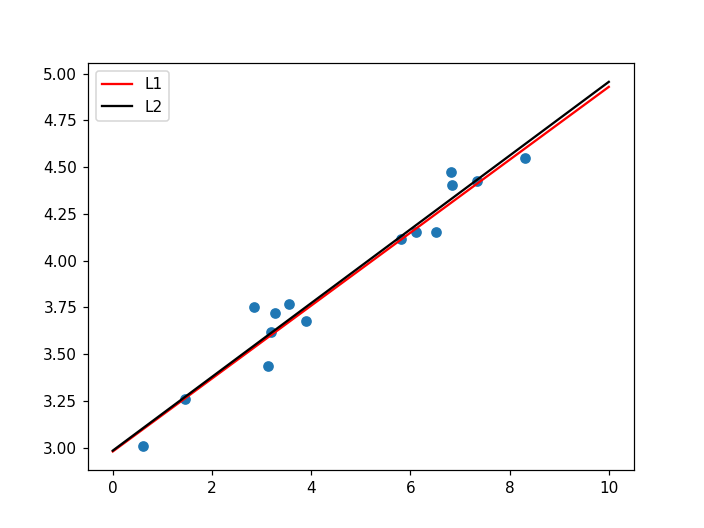

In [2]:
# generate some data with noise
x = np.sort(np.random.uniform(0, 10, 15))
y = 3 + 0.2 * x + 0.1 * np.random.randn(len(x))
# find L1 line fit
l1_fit = lambda x0, x, y: np.sum(np.abs(x0[0] * x + x0[1] - y))
xopt1 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y))

# find L2 line fit
l2_fit = lambda x0, x, y: np.sum(np.power(x0[0] * x + x0[1] - y, 2))
xopt2 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y))
plt.figure()
plt.plot(x,y,'o')
plt.plot([0,10],np.polyval(xopt1,[0,10]),'r',label='L1')
plt.plot([0,10],np.polyval(xopt2,[0,10]),'k',label='L2')
plt.gca().legend()
plt.show()

Optimization terminated successfully.
         Current function value: 7.798635
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 21.125241
         Iterations: 50
         Function evaluations: 97


<IPython.core.display.Javascript object>


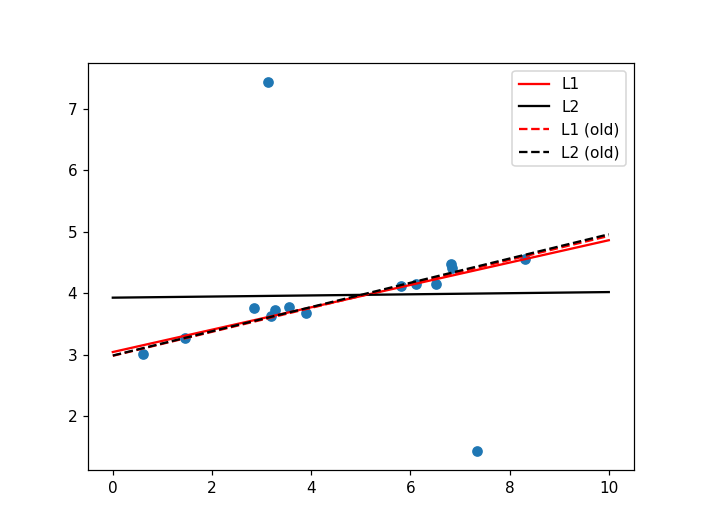

In [3]:
y2 = y.copy()
y2[3] += 4
y2[13] -= 3

# refit the lines
xopt12 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y2))
xopt22 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y2))
plt.figure()
plt.plot(x,y2,'o')
plt.plot([0,10],np.polyval(xopt12,[0,10]),'r',label='L1')
plt.plot([0,10],np.polyval(xopt22,[0,10]),'k',label='L2')
plt.plot([0,10],np.polyval(xopt1,[0,10]),'--r',label='L1 (old)')
plt.plot([0,10],np.polyval(xopt2,[0,10]),'--k',label='L2 (old)')
plt.gca().legend()
plt.show()

## Compressed sensing

In [4]:
n=25
m=30
A=np.random.randn(n,m)

def generate_x_y(num_non_zeros):
    x=np.zeros(m)
    x=np.random.rand(m)
    x[np.random.choice(range(m),m-num_non_zeros,replace=False)]=0    
    y=np.matmul(A,x)
    return x,y

def L1_norm(X):
    return np.abs(X).sum()

def L2_norm(X):
    return (X**2).sum()

<IPython.core.display.Javascript object>


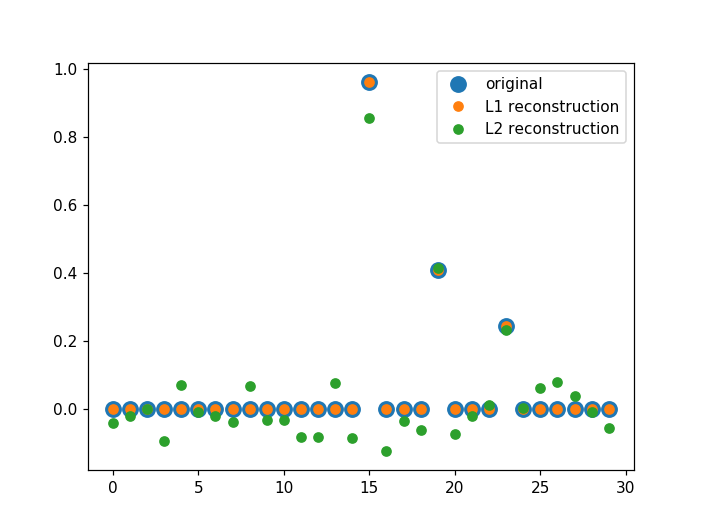

In [6]:
x, y=generate_x_y(3)
r1=spopt.minimize(fun=lambda X: L1_norm(X),x0=0*x,
                  constraints={'type': 'eq',
                               'fun' : lambda Q: np.matmul(A,Q)-y
                              })

r2=spopt.minimize(fun=lambda X: L2_norm(X),x0=0*x,
                  constraints={'type': 'eq',
                               'fun' : lambda Q: np.matmul(A,Q)-y
                              })
plt.figure()
plt.plot(x,'o',label='original',markersize=10)
plt.plot(r1.x,'o',label='L1 reconstruction')
plt.plot(r2.x,'o',label='L2 reconstruction')
plt.gca().legend()
plt.show()

In [37]:
nit=100
q1=np.zeros([m,nit])
q2=np.zeros([m,nit])
nnz=np.arange(1,m+1)
for i in nnz:
    for j in range(nit):
        x, y=generate_x_y(i)
        r1=spopt.minimize(fun=lambda X: L1_norm(X),x0=0*x,
                  constraints={'type': 'eq',
                               'fun' : lambda Q: np.matmul(A,Q)-y
                              })
        r2=spopt.minimize(fun=lambda X: L2_norm(X),x0=0*x,
                      constraints={'type': 'eq',
                                   'fun' : lambda Q: np.matmul(A,Q)-y
                                  })
        q1[i-1,j]=L2_norm(r1.x-x)
        q2[i-1,j]=L2_norm(r2.x-x)
        

<IPython.core.display.Javascript object>


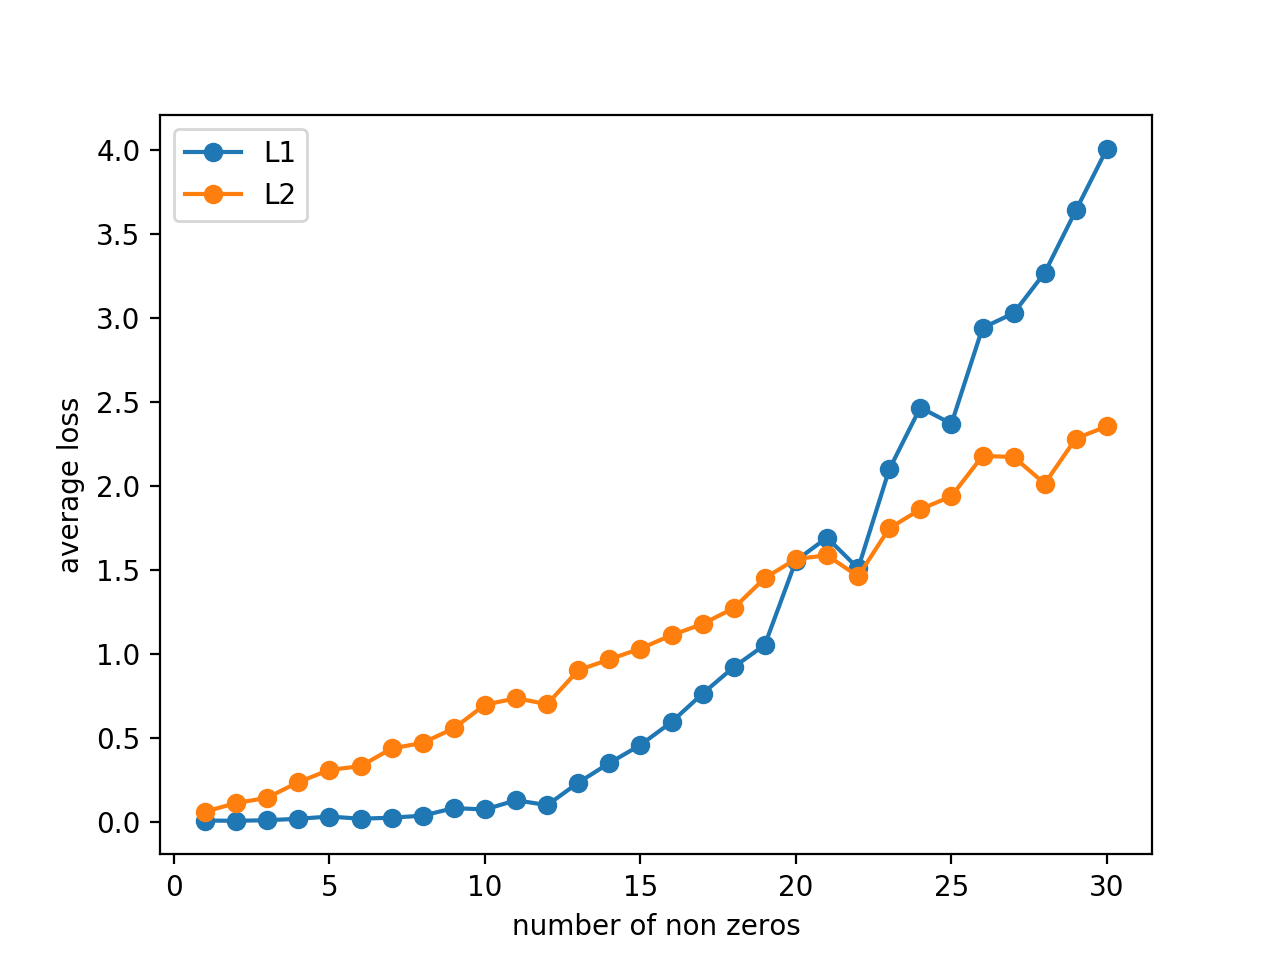

In [38]:
plt.figure()
plt.plot(range(1,m+1),q1.mean(axis=1),'-o', label='L1')
plt.plot(range(1,m+1),q2.mean(axis=1),'-o',label='L2')
plt.legend()
plt.gca().set_xlabel('number of non zeros')
plt.gca().set_ylabel('average loss')
plt.show()

# Hand-writing recognition

<IPython.core.display.Javascript object>


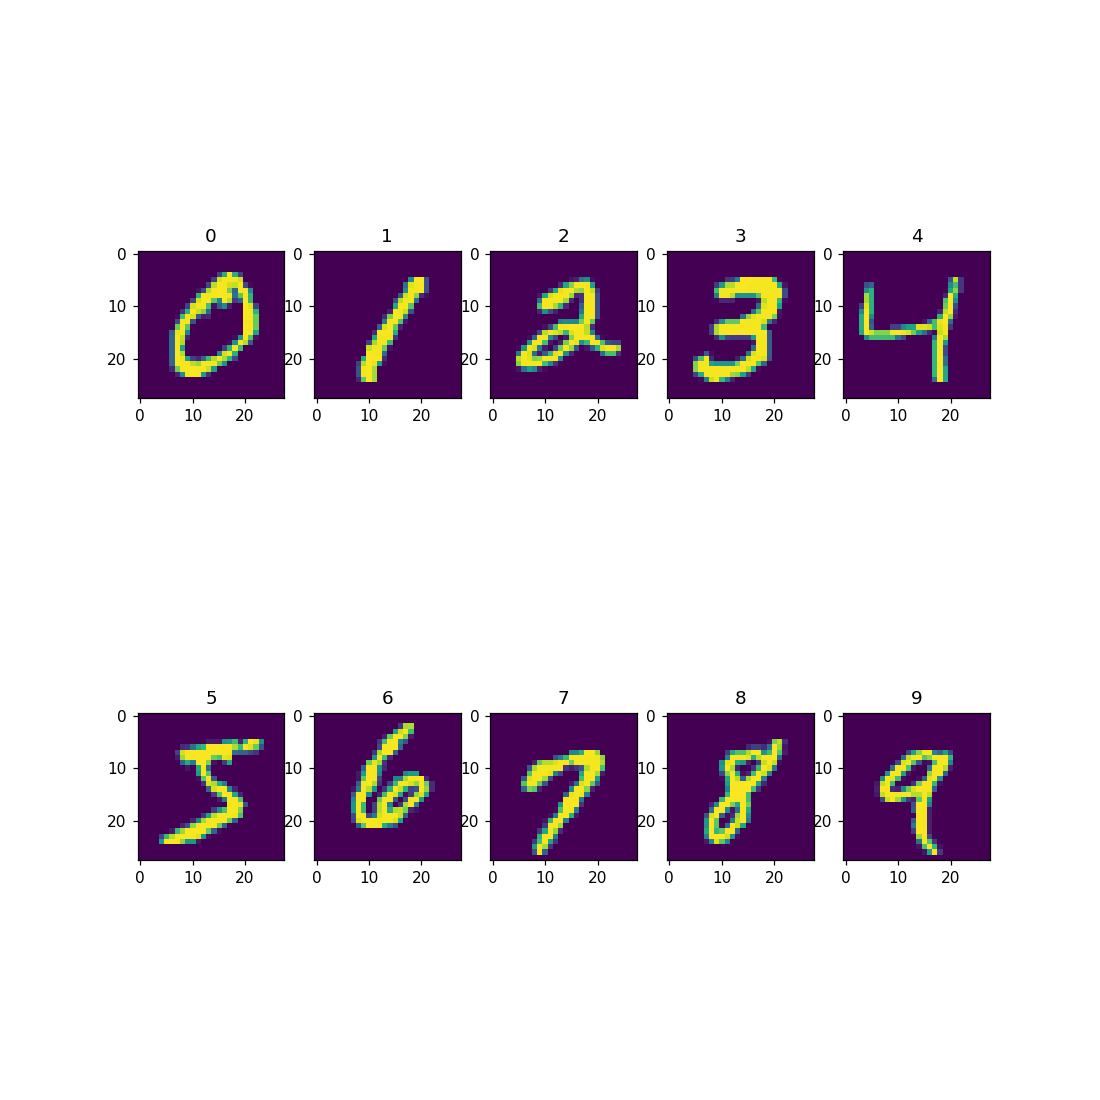

In [7]:
sk_mnist = fetch_mldata('MNIST original', data_home='/Users/yohai/data/sklearn')
inds=np.array([sk_mnist.target==i for i in range(10)]) # a list of the indices for label

f,ax=plt.subplots(2,5,figsize=(10,10))
ax=ax.flatten()
for i in range(10):
    ax[i].imshow(sk_mnist.data[np.argmax(inds[i])].reshape(28,28))
    ax[i].set_title(str(i))
plt.show()

plot two random projections:

<IPython.core.display.Javascript object>


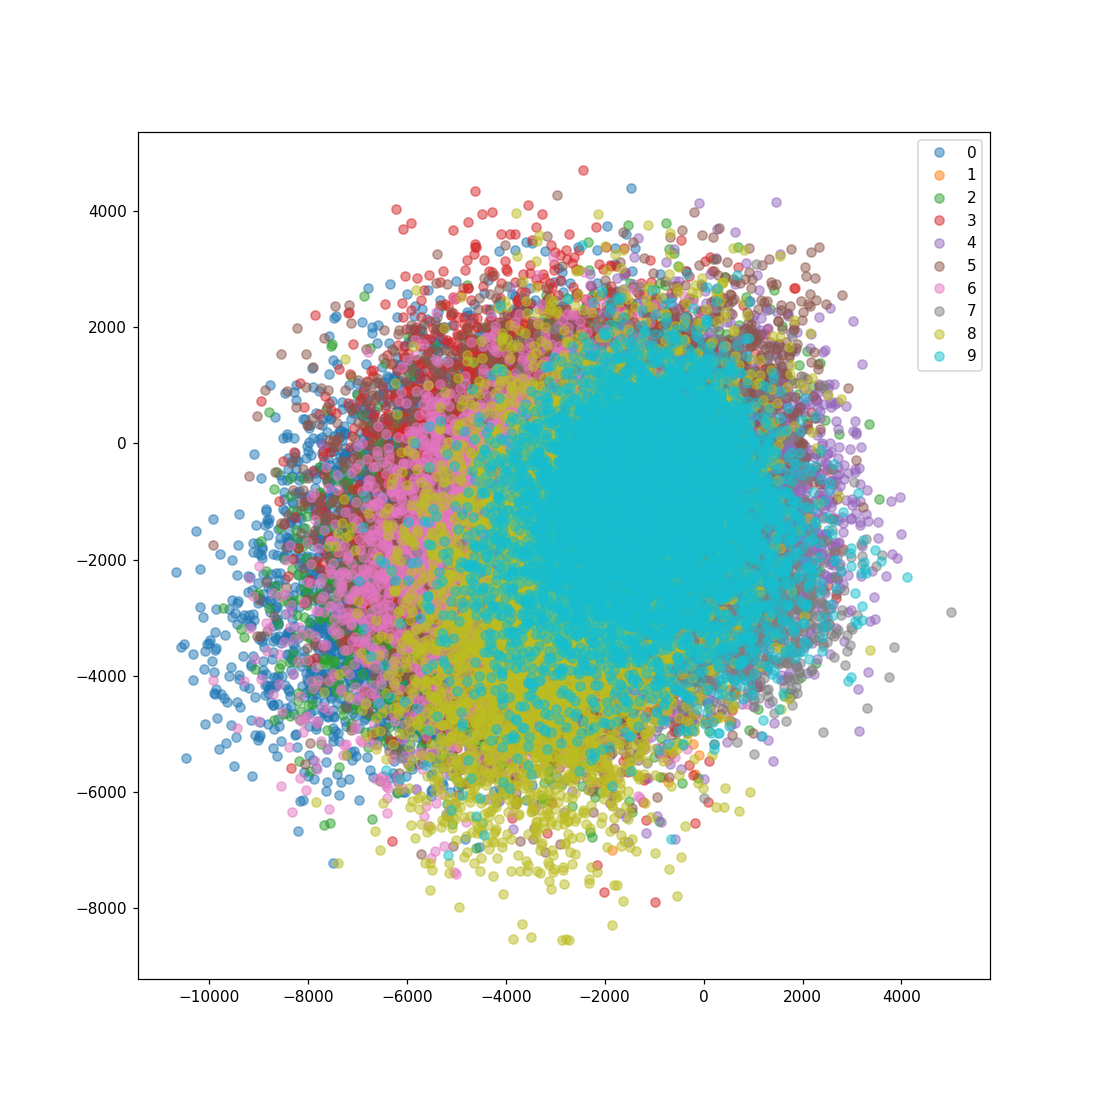

In [8]:
plt.figure(figsize=(10,10))
r1=np.random.randn(28*28)
r2=np.random.randn(28*28)
for i in range(10):
    plt.plot(np.dot(sk_mnist.data[inds[i]],r1),
             np.dot(sk_mnist.data[inds[i]],r2),
             'o', label=str(i), alpha=0.5)
plt.gca().legend()
plt.show()

Plot the two principal components from PCA:

<IPython.core.display.Javascript object>


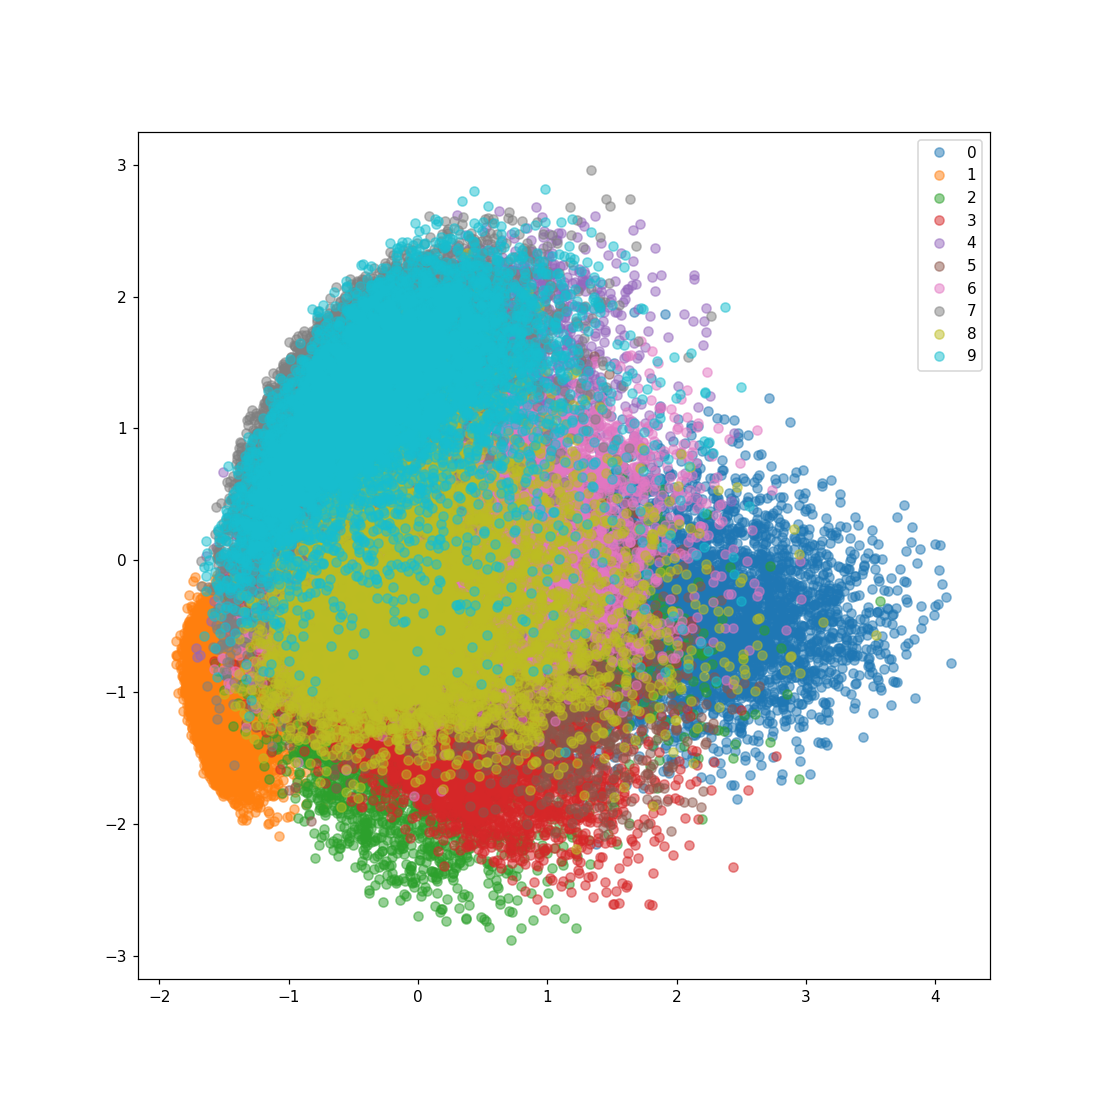

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20, whiten=True)
pca.fit(sk_mnist.data)
sk_mnist_reduced=pca.transform(sk_mnist.data)
plt.figure(figsize=(10,10))
for i in range(10):
    plt.plot(sk_mnist_reduced[inds[i],0],
             sk_mnist_reduced[inds[i],1],
             'o', label=str(i), alpha=0.5)
plt.gca().legend()
plt.show()

Preform KMeans clustering on the first 8 dimensions:

In [43]:
from sklearn.cluster import KMeans
k=KMeans(n_clusters=10)
k.fit(sk_mnist_reduced[:,:8]);

To evaluate results, we construct the matrix `mat` such that `mat[i,j]` is the number of digits of label `i` that are classified as belonging to cluster `j`

<IPython.core.display.Javascript object>


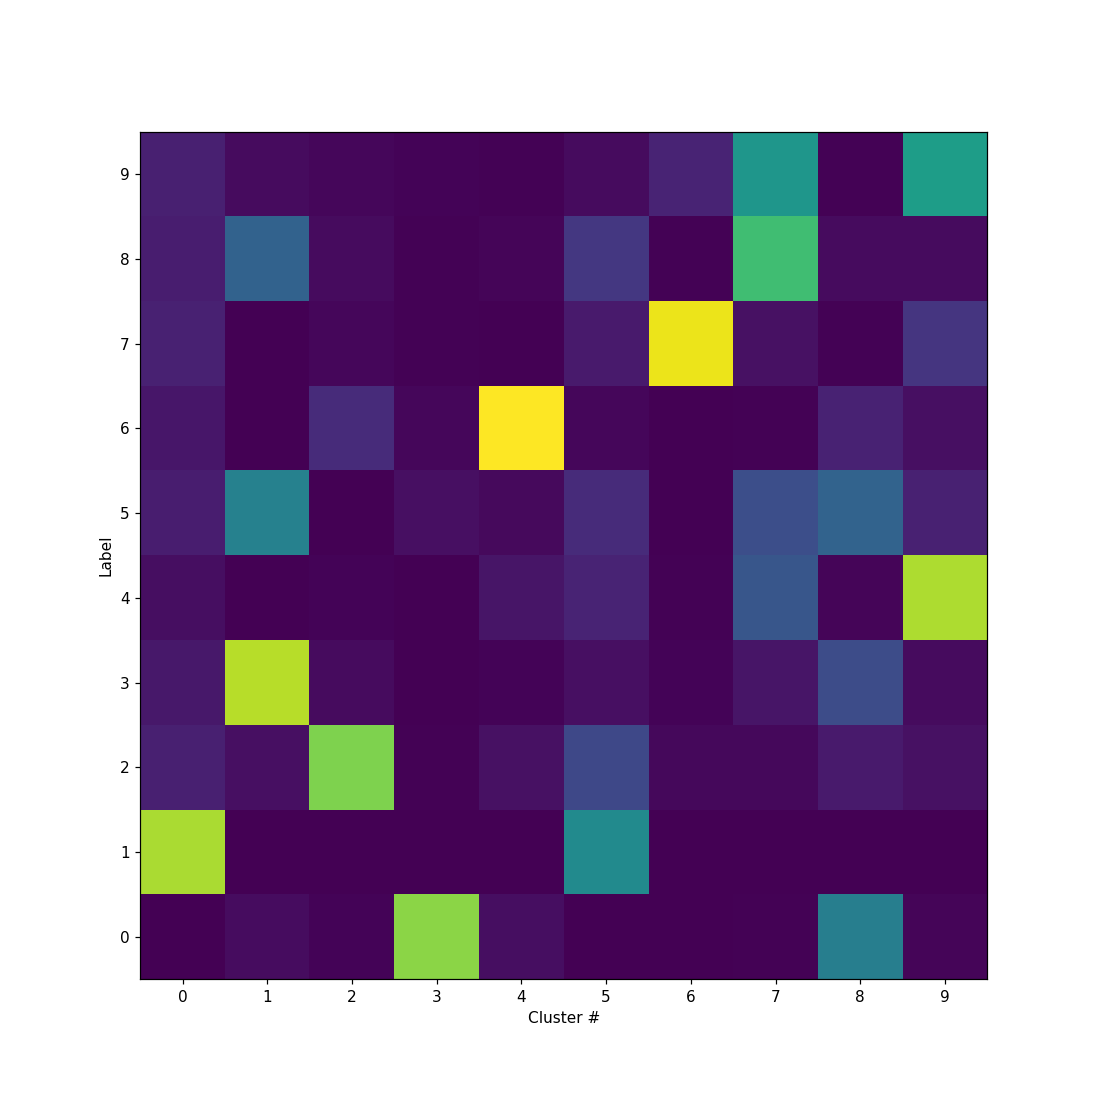

In [44]:
labels=[k.labels_[i][:6000] for i in inds]
#mat is matrix such that 
mat=np.array([np.bincount(l) for l in labels])
plt.figure(figsize=(10,10))
plt.gca().set_xticks(range(10))
plt.gca().set_yticks(range(10))
plt.gca().set_xlabel('Cluster #')
plt.gca().set_ylabel('Label')
plt.imshow(mat,origin='lower')
plt.show()

It looks like most clusters correspond quite overwhelmingly to a given label. Note though that some figures are harder to distinguish: 4 and 9, for example are both mapped to the 0 cluster. Also, 3 and 5 map to the 9th cluster. Note that we didn't divide the data to training and validation because I'm lazy.

# Neural Network

Load the `keras` mnist dataset and build a NN with one fully connected layer of 512 nodes and another fully connected softmax layer.

In [6]:
from keras.datasets import mnist as keras_mnist
(train_images, train_labels), (test_images, test_labels) = keras_mnist.load_data()
from keras import models
from keras import layers
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

#The data needs to be flattened before being fed into the network (this is not a ConvNet)
train_images_1d = train_images.reshape((60000, 28 * 28))
train_images_1d = train_images_1d.astype('float32') / 255
test_images_1d = test_images.reshape((10000, 28 * 28))
test_images_1d = test_images_1d.astype('float32') / 255

from keras.utils import to_categorical #this just converts the labels to one-hot class
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
h=network.fit(train_images_1d, train_labels, epochs=5, batch_size=128)

Using TensorFlow backend.


Epoch 1/5
60000/60000 [==============================] - 6s - loss: 0.2565 - acc: 0.9263     
Epoch 2/5
60000/60000 [==============================] - 6s - loss: 0.1040 - acc: 0.9691     
Epoch 3/5
60000/60000 [==============================] - 6s - loss: 0.0695 - acc: 0.9793     
Epoch 4/5
60000/60000 [==============================] - 6s - loss: 0.0501 - acc: 0.9848     
Epoch 5/5
60000/60000 [==============================] - 6s - loss: 0.0377 - acc: 0.9890     


Construct again the matrix that shows how many of each label were classified as which label

<IPython.core.display.Javascript object>


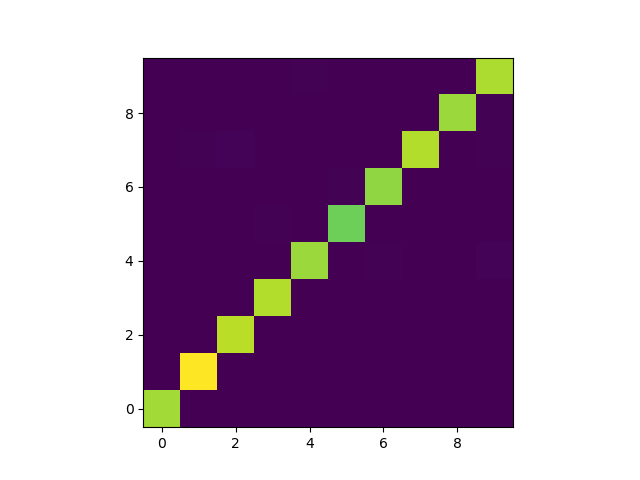

In [7]:
predictions=np.argmax(network.predict(test_images_1d),axis=1)
keras_mat=np.zeros([10,10],dtype='i')
label_v=test_labels.argmax(axis=1)
for i in range(10):
    for j in range(10):
        keras_mat[i,j]=np.bitwise_and(label_v==i , predictions==j).sum()
plt.figure()
plt.imshow(keras_mat,origin='lower')
plt.show()

This is much better, as you can clearly see. Note, though, that the error in the training set is lower than that of the validation set, a sign of overfitting:

In [46]:
print "Train loss is %f and accuracy is %f"      %  tuple(network.evaluate(train_images_1d, train_labels, verbose=0))
print "Validation loss is %f and accuracy is %f" %  tuple(network.evaluate(test_images_1d, test_labels, verbose=0))

Train loss is 0.022198 and accuracy is 0.993983
Validation loss is 0.063748 and accuracy is 0.980600
